In [6]:
import scipy
#import pytrends
#from pytrends.request import TrendReq
from numpy import random
import matplotlib.pyplot as plt
from scipy import optimize
import sys
import time
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json
from datetime import datetime, timedelta
from county_spending import get_county_spending, spend_county_state_map, us_state_abbrev, abbrev_us_state
from ACS_data import colname_mask
import re
import pickle
import requests
pd.set_option('display.max_columns', None)

In [3]:
class endpoint_graph():
    def __init__(self, gdict=None):
        if gdict==None:
            gdict = []
        self.gdict = gdict

    
        
        

In [39]:
# http://jeffreyfossett.com/2017/05/07/querying-usa-spending-python.html

# goal of this function is to get
# 1. Covid only relief spending (def_codes)
# 2. Filtered by department/agency
# 3. In a dream world we have businesses and hospital per county as well. 
#
# Can't get from api/v2/disaster need to go through api/v2/search

def post_usaspending(query='agency', just_health=False):
    
    query_dict = {'agency':'/api/v2/disaster/agency/spending/',
                 'cfda':'/api/v2/disaster/cfda/spending/', # v long
                 'fed_acct':'/api/v2/disaster/federal_account/spending/',
                 'search_geo':'/api/v2/search/spending_by_geography/',
                 'toptier':'/api/v2/references/toptier_agencies/',
                 'dis_geo':'/api/v2/disaster/spending_by_geography/'}
    
    q = query_dict[query]

    # initialization
    has_next_page = True
    page = 1
    output = []

   # while has_next_page:
    payload =  {
  "filter": {
      "def_codes": ["L", "M", "N", "O", "P", "U"]
  },
  "geo_layer": "county",
 # "geo_layer_filters": ["NE", "WY", "CO", "IA", "IL", "MI", "IN", "TX"],
  "scope": "recipient_location",
  "spending_type": "obligation"
}


    r = requests.post('https://api.usaspending.gov'+q, json=payload)
    #print(r.text)
    rjson = r.json()
    output+= rjson['results']
    #has_next_page = rjson['page_metadata']['hasNext']
    page+=1
    print(r.status_code, page)
    return output

In [38]:
post_usaspending('dis_geo')

200 2


{'geo_layer': 'county',
 'spending_type': 'obligation',
 'scope': 'recipient_location',
 'results': [{'amount': 32848306171.16,
   'display_name': 'Los Angeles',
   'shape_code': '06037',
   'population': 10039107,
   'per_capita': 3272.03,
   'award_count': 747836},
  {'amount': 8909569577.95,
   'display_name': 'Miami-Dade',
   'shape_code': '12086',
   'population': 2716940,
   'per_capita': 3279.27,
   'award_count': 423598},
  {'amount': 27132210710.36,
   'display_name': 'Cook',
   'shape_code': '17031',
   'population': 5150233,
   'per_capita': 5268.15,
   'award_count': 398169},
  {'amount': 13480970276.03,
   'display_name': 'Harris',
   'shape_code': '48201',
   'population': 4713325,
   'per_capita': 2860.18,
   'award_count': 280146},
  {'amount': 6607328901.56,
   'display_name': 'Broward',
   'shape_code': '12011',
   'population': 1952778,
   'per_capita': 3383.55,
   'award_count': 226534},
  {'amount': 11492189568.89,
   'display_name': 'Orange',
   'shape_code': '060

In [67]:
response = post_usaspending()
response

agencies = ['Department of Labor', 'Department of Veterans Affairs', 'Department of Transportation',
           'Department of Health and Human Services', 'Department of Education', 'Department of Housing and Urban Development']

agency_dict = {}
for i in response:
    if i['description'] in agencies:
        agency_dict[i['description']] = {'id':i['id'], 'code':i['code']}
agency_dict

ConnectionError: HTTPSConnectionPool(host='api.usaspending.govapi', port=443): Max retries exceeded with url: /v2/disaster/agency/spending/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f2184a2b7d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))

{'Department of Education': {'id': 1068, 'code': '091'}, 'Department of Housing and Urban Development': {'id': 882, 'code': '086'}, 'Department of Health and Human Services': {'id': 806, 'code': '075'}, 'Department of Transportation': {'id': 731, 'code': '069'}, 'Department of Veterans Affairs': {'id': 561, 'code': '036'}, 'Department of Labor': {'id': 267, 'code': '1601'}}

In [62]:
print(agency_dict)

f = open('agency_dict.pkl', 'wb')
pickle.dump(agency_dict, f)
f.close()

{'Department of Education': {'id': 1068, 'code': '091'}, 'Department of Housing and Urban Development': {'id': 882, 'code': '086'}, 'Department of Health and Human Services': {'id': 806, 'code': '075'}, 'Department of Transportation': {'id': 731, 'code': '069'}, 'Department of Veterans Affairs': {'id': 561, 'code': '036'}, 'Department of Labor': {'id': 267, 'code': '1601'}}


In [65]:
f=open('agency_dict.pkl', 'r+')
agency_dict = pickle.load(f)
agency_dict

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

<BarContainer object of 38 artists>

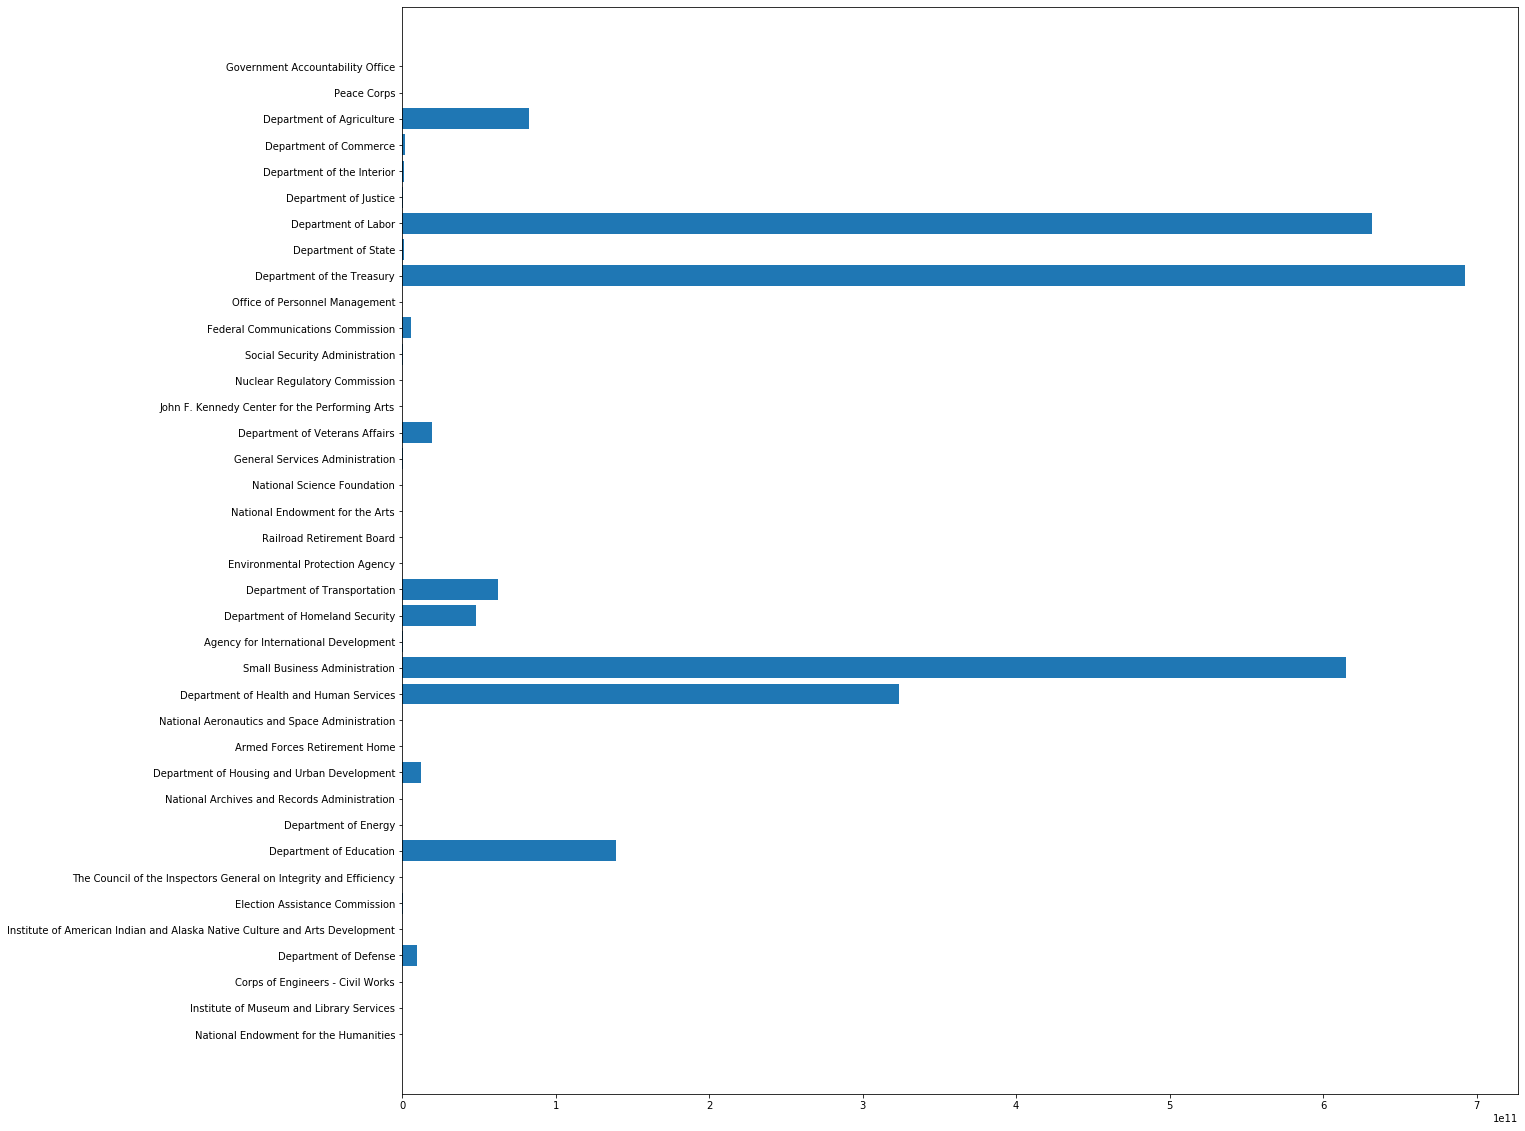

In [53]:
labels = [i['description'] for i in response]
awards = [i['total_budgetary_resources'] for i in response]

plt.figure(figsize=(20,20))
plt.barh(labels,awards)
#plt.xticks(rotation=90)


In [1]:
3*10**11

300000000000

In [13]:
def geo_search():
    
    q = '/api/v2/search/spending_by_geography/'

    # initialization
    has_next_page = True
    page = 1
    output = []

    #while has_next_page:
    payload =   {
  "filters": {
      #"keywords": ["Filter is required"],
      "agencies":[{
          "type":"awarding",
          "tier":"toptier",
          "name":"Department of Health and Human Services"
      },
      {
          "type":"awarding",
          "tier":"toptier",
          "name":"Department Education"
      },
      {
          "type":"awarding",
          "tier":"toptier",
          "name":"Department of Housing and Urban Development"
      },], 
      "time_period":[{
          "start_date":"2020-02-06",
          "end_date":"2021-03-01"
      }]
  },
  "scope": "recipient_location",
  "geo_layer": "county"
}

    r = requests.post('https://api.usaspending.gov'+q, json=payload)
    print(r.text)
    rjson = r.json()
    print(rjson)
    output+= rjson['results']
   # has_next_page = rjson['page_metadata']['hasNext']
    #page+=1
    print(r.status_code, page)
    return output

In [40]:
# With Dep Health Suffolk "aggregated_amount":19440707238.44
# With Dep Health Suffolk "aggregated_amount":172477803663.77
geo_dep_health = geo_search()
geo_all = post_usaspending('dis_geo')

{"scope":"recipient_location","geo_layer":"county","results":[{"shape_code":"34005","aggregated_amount":-961301181.21,"display_name":"Burlington","population":445349,"per_capita":-2158.53},{"shape_code":"06111","aggregated_amount":-725863216.01,"display_name":"Ventura","population":846006,"per_capita":-857.99},{"shape_code":"06059","aggregated_amount":3350485628.84,"display_name":"Orange","population":3175692,"per_capita":1055.04},{"shape_code":"48113","aggregated_amount":1022205609.17,"display_name":"Dallas","population":2635516,"per_capita":387.86},{"shape_code":"26163","aggregated_amount":8943813687.2,"display_name":"Wayne","population":1749343,"per_capita":5112.67},{"shape_code":"12086","aggregated_amount":7563937131.32,"display_name":"Miami-Dade","population":2716940,"per_capita":2783.99},{"shape_code":"42091","aggregated_amount":-247787770.03,"display_name":"Montgomery","population":830915,"per_capita":-298.21},{"shape_code":"39035","aggregated_amount":1185243425.81,"display_name

In [32]:
{'amount': 32848306171.16,
   'display_name': 'Los Angeles',
   'shape_code': '06037',
   'population': 10039107,
   'per_capita': 3272.03,
   'award_count': 747836},

{'shape_code': '25025',
 'aggregated_amount': 19440707238.44,
 'display_name': 'Suffolk',
 'population': 803907,
 'per_capita': 24182.78}

In [42]:

init_data = {'shape_code': [i['shape_code'] for i in geo_all[:]],
 'amount': [i['amount'] for i in geo_all[:]],
 'display_name': [i['display_name'] for i in geo_all[:]],
 'population': [i['population'] for i in geo_all[:]],
 'per_capita': [i['per_capita'] for i in geo_all[:]],
 'award_count': [i['award_count'] for i in geo_all[:]]}


#init_data = geo_dep_health[0]
gdh_df = pd.DataFrame(data=init_data)


#gdh_df = pd.read_json(geo_dep_health.json())

In [43]:
gdh_df

,shape_code,amount,display_name,population,per_capita,award_count
0,06037,3.284831e+10,Los Angeles,10039107.0,3272.03,747836
1,12086,8.909570e+09,Miami-Dade,2716940.0,3279.27,423598
2,17031,2.713221e+10,Cook,5150233.0,5268.15,398169
3,48201,1.348097e+10,Harris,4713325.0,2860.18,280146
4,12011,6.607329e+09,Broward,1952778.0,3383.55,226534
...,...,...,...,...,...,...
3228,53023,1.185040e+05,Garfield,2225.0,53.26,11
3229,68020,8.270648e+06,None,NaN,NaN,6
3230,48261,2.558806e+05,Kenedy,404.0,633.37,4
3231,48301,3.224720e+04,Loving,169.0,190.81,4


In [ ]:
spend_county_state_map